In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*`torch.cuda.amp.autocast.*")
import torch
import numpy as np
import random
import PIL.Image
import matplotlib.pyplot as plt
from types import SimpleNamespace
from datasets import load_dataset
from timm.optim import Adan
from torchvision.transforms.v2 import (
    Compose, Resize, RandomCrop, CenterCrop, RandomHorizontalFlip,
    PILToTensor, ToPILImage, CutMix, MixUp)
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import display, HTML

In [2]:
torch.set_float32_matmul_precision('highest')
device = "cuda:3"
dataset_train = load_dataset('danjacobellis/imagenet_288_webp',split='train')
dataset_valid = load_dataset('danjacobellis/imagenet_288_webp',split='validation')

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

In [3]:
config = SimpleNamespace()
# Training and optimizer config
config.batch_size = 128
config.steps_per_epoch = dataset_train.num_rows//config.batch_size
config.grad_accum_steps = 1
config.max_lr = (config.batch_size/256)*2e-2
config.lr_pow = 1.0
config.plot_update = 128
config.epochs = 20
config.steps = config.epochs*config.steps_per_epoch

config.weight_decay = 0.0
config.num_workers = 32
config.max_crop_size = 288
config.valid_crop_size = 288

# model config
config.channels = 3
config.classifier_num_classes = 1000
config.checkpoint = False

In [4]:
from timm.models.efficientvit_mit import EfficientVitLarge, GELUTanh
class GroupNorm8(torch.nn.Module):
    def __init__(self, num_features, eps=1e-7, affine=True):
        super().__init__()
        self.groupnorm = torch.nn.GroupNorm(num_groups=8,
                                      num_channels=num_features,
                                      eps=eps,
                                      affine=affine)
    def forward(self, x):
        return self.groupnorm(x)
model = EfficientVitLarge(
    in_chans=config.channels,
    widths=(32, 64, 128, 256, 512),
    depths=(1, 1, 1, 6, 6),
    head_dim=32,
    norm_layer=GroupNorm8,
    act_layer=GELUTanh,
    global_pool='avg',
    head_widths=(3072, 3200),
    drop_rate=0.0,
    num_classes=config.classifier_num_classes
)
model.head.in_conv.norm = torch.nn.GroupNorm(
    num_groups=8,
    num_channels=model.head.in_conv.norm.num_features,
    affine=model.head.in_conv.norm.affine,
    eps=model.head.in_conv.norm.eps
)
model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6)
for name, module in model.named_children():
    print(f"{sum(p.numel() for p in module.parameters())/1e6} \t {name}")

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint, map_location="cpu", weights_only=False)
    model.load_state_dict(checkpoint['model'])

52.654088
0.019488 	 stem
38.017792 	 stages
14.616808 	 head


In [5]:
optimizer = Adan(
    params=model.parameters(),
    lr=1.0,
    weight_decay=config.weight_decay,
    caution=True
)
def rc_sched(i_step, config):
    t = i_step / (config.steps / config.plot_update)
    return config.max_lr*0.5 * (1 - np.cos(2*np.pi*(t**config.lr_pow))) + 1e-15
    return lr
schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: rc_sched(i_step, config),
)

In [6]:
# learning_rates = [optimizer.param_groups[0]['lr']]
# i_step = 0
# for i_epoch in range(config.epochs):
#     for i_batch in range(config.steps_per_epoch):
#         if (i_step+1) % config.plot_update == 0:
#             schedule.step()
#             learning_rates.append(optimizer.param_groups[0]['lr'])
#         i_step+=1
# fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
# axes[0].semilogy(learning_rates);axes[0].set_ylim([1e-6, 1.0])
# axes[1].plot(learning_rates);

In [6]:
mix_transforms = [
    CutMix(num_classes=config.classifier_num_classes),
    MixUp(num_classes=config.classifier_num_classes)
]
crop_size = lambda i_epoch : int(32*((((i_epoch+1)*(config.max_crop_size**2)/config.epochs)**0.5)//32))
cent_crop = Compose([
    Resize(config.valid_crop_size, interpolation=PIL.Image.Resampling.LANCZOS),
    CenterCrop(size=config.valid_crop_size),
    PILToTensor()
])
def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.valid_crop_size, config.valid_crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['cls']
        x[i_sample,:,:,:] = cent_crop(sample['webp'])
    x = x.to(torch.float) / 127.5 - 1.0
    y = y.to(torch.long)
    return (x,y)

In [ ]:
mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
train_loss = []
valid_acc = []
learning_rates = [optimizer.param_groups[0]['lr']]
i_step = 0
for i_epoch in mb:
    # training
    model.train()
    rand_crop = Compose([
        Resize(crop_size(i_epoch), interpolation=PIL.Image.Resampling.LANCZOS),
        RandomHorizontalFlip(1.0 if i_epoch%2 else 0.0),
        RandomCrop((crop_size(i_epoch),crop_size(i_epoch))),
        PILToTensor()
    ])
    def train_collate_fn(batch):
        B = len(batch)
        x = torch.zeros((B, config.channels, crop_size(i_epoch), crop_size(i_epoch)), dtype=torch.uint8)
        y = torch.zeros(B, dtype=torch.int)
        for i_sample, sample in enumerate(batch):
            y[i_sample] = sample['cls']
            x[i_sample,:,:,:] = rand_crop(sample['webp'])
        x = x.to(torch.float) / 127.5 - 1.0
        y = y.to(torch.long)
        return x, y

    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        y = y.to(torch.long).to(device)
        x = x.to(device)
        for mix_transform in mix_transforms:
            x, y = mix_transform(x, y) 

        logits = model(x)
        loss = torch.nn.CrossEntropyLoss()(input=logits, target=y)

        train_loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0, norm_type=2.0)
        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # plotting and learning rate update
        if (i_step+1) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr update
            schedule.step()
            learning_rates.append(optimizer.param_groups[0]['lr'])
    
        i_step+=1
        
    # validation
    model.eval()
    valid_acc.append(0)
    data_loader_valid = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    for i_batch, (x, y) in enumerate(pb_valid):
        y = y.to(device)
        x = x.to(device)
        with torch.no_grad():
            logits = ( model(x) + model(torch.flip(x, dims=[3])) ) / 2
        valid_acc[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    valid_acc[i_epoch] /= len(dataset_valid)
    
    mb.main_bar.comment = f'valid_acc {valid_acc[i_epoch]:.4g}'
    
    torch.save({
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_acc': valid_acc,
        'config': config,
        'model_state_dict': model.state_dict(),
    }, f"log_{device}_2.pth")

In [9]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

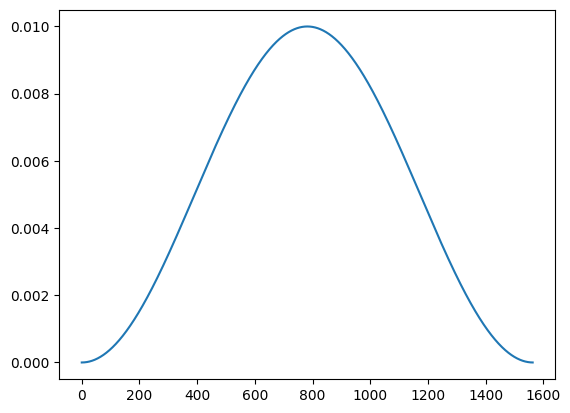

In [10]:
plt.plot(learning_rates)

/tmp/ipykernel_590581/2432266517.py:2: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,7])


(2.600266924894538, 7)

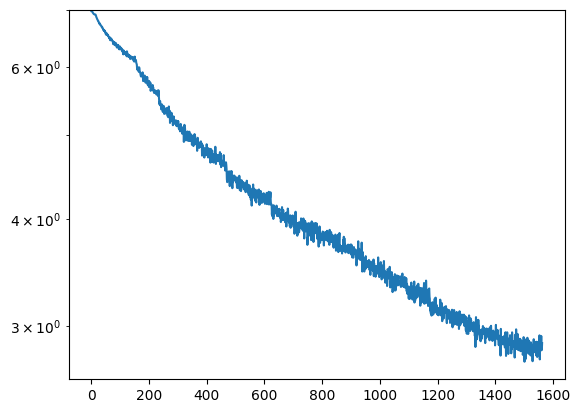

In [11]:
plt.semilogy(smoothed_y)
plt.ylim([0,7])

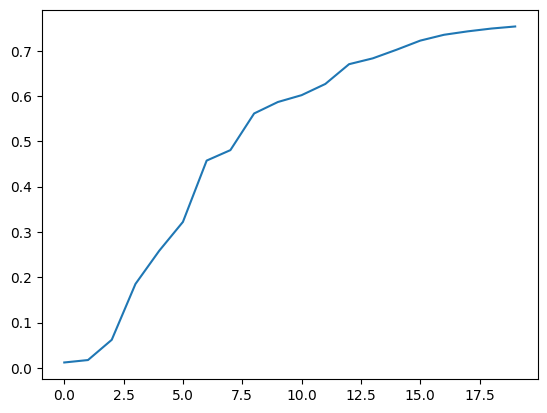

In [12]:
plt.plot(valid_acc)

In [ ]:
###### torch.save({
#     'i_epoch': i_epoch,
#     'learning_rates': learning_rates,
#     'smoothed_y': smoothed_y,
#     'valid_acc': valid_acc,
#     'config': config,
#     'model': model.state_dict(),
#     'optimizer': optimizer.state_dict(),
# }, f"../../hf/tft/efficientvit_l1_gn8.pth")